## Choosing hyperparameters for GAiA's neural network

In this notebook, we are trying different numbers of SE-ResNet blocks for our final model.

In [1]:
import sys
sys.path.insert(1, "lib/")
sys.path.insert(1, "model/")
from GAiA_network import GAiA_Network, coeff_determination
from dataset_utils import read_many_hdf5, board_shape

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import platform
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

if tf.test.gpu_device_name(): 
  print(f"Default GPU Device: {tf.test.gpu_device_name()}")

Default GPU Device: /device:GPU:0


2021-11-26 20:08:57.243386: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-26 20:08:57.566312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:08:57.763685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:08:57.764697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

We are loading our training dataset and we are using it to build different training and validation data
for each model.

In [2]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
positions, scores = read_many_hdf5(1389689, directory, "_train")
positions = positions[:250000]
scores = scores[:250000]

nb_models = 10
positions_train, scores_train = [], []
positions_valid, scores_valid = [], []
for i in range(nb_models):
  positions_train_t, positions_valid_t, scores_train_t, scores_valid_t = train_test_split(
    positions, scores, test_size=0.2, random_state=42+i)
  positions_train.append(positions_train_t)
  positions_valid.append(positions_valid_t)
  scores_train.append(scores_train_t)
  scores_valid.append(scores_valid_t)
print(f"Training sets shape ≈ {positions_train[0].shape}, Validation sets shape ≈ {positions_valid[0].shape}")


Training sets shape ≈ (200000, 8, 8, 15), Validation sets shape ≈ (50000, 8, 8, 15)


Now, we create several models with an increasing number of SE-ResNet blocks.

In [3]:
models = []
offset_blocks = 2
filters = [64, 128]
for i in range(1, nb_models+1):
  model = GAiA_Network(board_shape, {"filters":filters[(i-1) // (nb_models//2)], "nb_blocks":i+offset_blocks})
  model.compile(loss="mean_absolute_error", optimizer="adam", metrics=[coeff_determination])
  models.append(model)
models[0].summary()

2021-11-26 20:09:05.934427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:09:05.934766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:09:05.934938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:09:05.935400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 20:09:05.935579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "GAiA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 15)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     1024        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 64)    256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 8, 8, 64)     0           ['batch_normalization[0][0]'] 

We train our models.

In [4]:
nb_epochs = 30
histories = []
for i, model in enumerate(models):
  print(f"Model {i+1}/{len(models)}...", end=" ")
  history = model.fit(positions_train[i], scores_train[i], verbose=0, epochs=nb_epochs)
  histories.append(history)
  pred = model.predict(positions_train[i])
  r2_score = coeff_determination(tf.convert_to_tensor(scores_train[i]), pred).numpy()
  print(f"Done. Training accuracy: {r2_score:.2f}")


Model 1/10... 

2021-11-26 20:09:09.593677: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768000000 exceeds 10% of free system memory.
2021-11-26 20:09:10.060441: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768000000 exceeds 10% of free system memory.
2021-11-26 20:09:13.578047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-11-26 20:26:27.979973: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768000000 exceeds 10% of free system memory.
2021-11-26 20:26:28.435794: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768000000 exceeds 10% of free system memory.


Done. Training accuracy: 0.91
Model 2/10... 

2021-11-26 20:26:42.263166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768000000 exceeds 10% of free system memory.


Done. Training accuracy: 0.92
Model 3/10... Done. Training accuracy: 0.92
Model 4/10... Done. Training accuracy: 0.92
Model 5/10... Done. Training accuracy: 0.92
Model 6/10... Done. Training accuracy: 0.92
Model 7/10... Done. Training accuracy: 0.92
Model 8/10... Done. Training accuracy: 0.93
Model 9/10... Done. Training accuracy: 0.90
Model 10/10... Done. Training accuracy: 0.93


In [7]:
def plot_validation_results(histories, validation_Xs, validation_ys, path=None, ext="pdf"):
  epochs = range(1, nb_epochs + 1)

  f, axs = plt.subplots(1, 2, figsize=(20, 5))
  _, ax_score  = plt.subplots(1, 1, figsize=(10, 5))

  line_styles = ["-", "--", "-.", ":", ".-"]

  for i, history in enumerate(histories):
    X_valid = validation_Xs[i]
    y_valid = validation_ys[i]
    nb_blocks = i + offset_blocks + 1
    nb_filters = filters[i // (nb_models//2)]

    loss = history.history["loss"]
    score = history.history["coeff_determination"]
    style = line_styles[i % len(line_styles)]
    axs[0].plot(epochs, loss, style, label=f"{nb_blocks} SE-ResNet blocks {nb_filters} filters")

    axs[1].plot(epochs, score, style, label=f"{nb_blocks} SE-ResNet blocks {nb_filters} filters")

    preds = models[i].predict(X_valid)
    r2_score = coeff_determination(tf.convert_to_tensor(y_valid), preds).numpy()
    ax_score.scatter(y_valid, preds, label = f"{nb_blocks} SE-ResNet blocks  {nb_filters} filters $R^2 = {r2_score:.2f}$")


  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("(Mean Absolute Error)")
  axs[0].set_title('Training loss')
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("($R^2$)")
  axs[1].set_title('Training score')
  for ax in axs:
    ax.legend()

  if path:
    f.savefig(path + "_1." + ext)

  ma = np.max(y_valid)
  mi = np.min(y_valid)
  x = np.linspace(ma, mi, 100)
  ax_score.plot(x, x, "-.", label = "Predictions = True values")
  ax_score.set_xlabel("True values (centipawn)")
  ax_score.set_ylabel("Predictions (centipawn)")
  ax_score.set_title("Results on validation set")
  ax_score.legend()

  if path:
    plt.savefig(path + "_2." + ext)

def get_best_model(models, validation_Xs, validation_ys):
  preds = []
  for i in range(len(models)):
    pred = models[i].predict(validation_Xs[i])
    r2_score = coeff_determination(tf.convert_to_tensor(validation_ys[i]), pred).numpy()
    preds.append(r2_score)
  idx = np.argmax(preds)+1
  return models[idx], offset_blocks + idx, filters[idx // (nb_models//2)]

Here are the results!

/tmp/ipykernel_8554/1643026892.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(path + "_2." + ext)
/tmp/ipykernel_8554/1643026892.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(path + "_2." + ext)


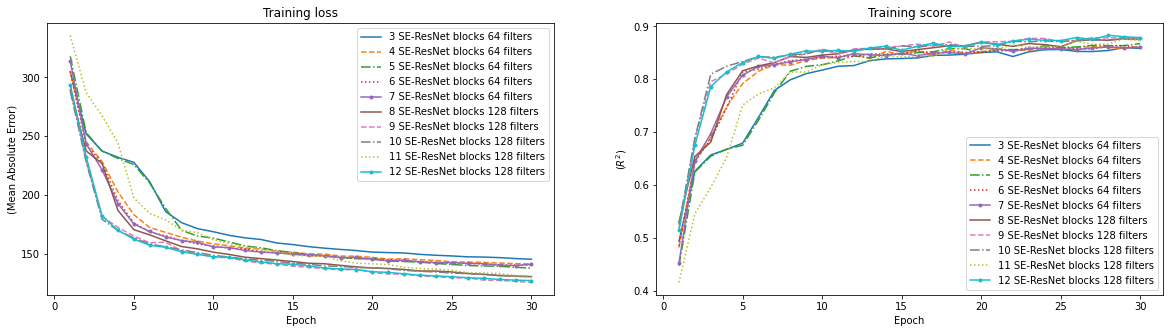

/home/gaetan/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


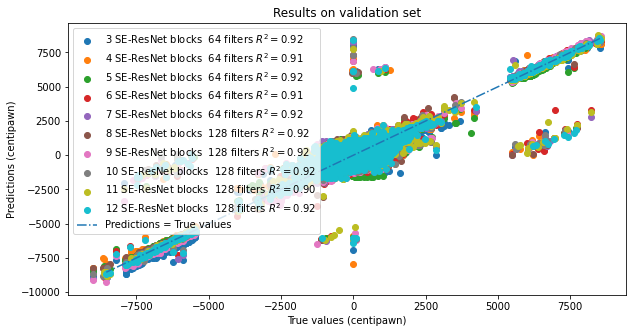

In [8]:
plot_validation_results(histories, positions_valid, scores_valid, path="results/model_selection")

We can see on the figure above that all of our model perform well.

However, adding more blocks and filters do not improve the results.

Therefore, we can take the less complex one.

In [11]:
config = {"nb_blocks": 3, "filters": 64}
print(config)
output_file = open("model/hyperparameters.pickle", "wb")
pickle.dump(config, output_file)
output_file.close()

{'nb_blocks': 3, 'filters': 64}
